In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
import sklearn
%matplotlib inline

/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
np.random.seed(0)
x,y=sklearn.datasets.make_moons(200,noise=0.20)

In [3]:
y=y.reshape(200,1)

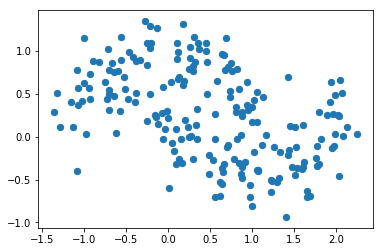

In [4]:
plt.scatter(x[:,0],x[:,1],cmap=plt.cm.Spectral,s=40)

In [5]:
x=x.reshape(x.shape[0],-1).T
y=y.reshape(y.shape[0],-1).T

In [6]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z)),Z

In [7]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [8]:
def tanh_backward(dA, cache):
    Z = cache
    dZ = dA * (1-(np.tanh(Z)*np.tanh(Z)))
    return dZ

In [9]:
def initialize_parameters(layer_dims):
    parameters={}
    l=len(layer_dims)
    for i in range(1,l):
        parameters['W'+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])*0.01
        parameters['b'+str(i)]=np.zeros((layer_dims[i],1))
    return parameters    

In [10]:
def linear_forward(A,W,b):
    Z=np.dot(W,A)+b
    cache=(A,W,b)
    return Z,cache

In [11]:
def linear_activation_forward(A_prev,W,b,activation):
    if(activation=='tanh'):
        Z,linear_cache=linear_forward(A_prev,W,b)
        A=np.tanh(Z)
        activation_cache=Z
    elif(activation=='sigmoid'):
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=sigmoid(Z)
    cache=(linear_cache,activation_cache)
    return A,cache

In [12]:
def L_model_forward(X,parameters):
    caches=[]
    l=len(parameters)//2
    A_prev=X
    for i in range(1,l):
        A,cache=linear_activation_forward(A_prev,parameters['W'+str(i)],parameters['b'+str(i)],'tanh')
        caches.append(cache)
        A_prev=A
    A,cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'sigmoid')
    caches.append(cache)
    return A,caches    

In [13]:
def compute_cost(A,Y):
    m=Y.shape[1]
    cost = (-1./ m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1-A)))
    cost=np.squeeze(cost)
    return cost

In [14]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1. / m) * np.dot(dZ, cache[0].T) 
    db = (1. / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation="tanh")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [17]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [18]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(W1,x) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(W2,a1) + b2
    a2,z2=sigmoid(z2)
    for i in range(a2.shape[1]):
        if(a2[0,i]>0.5):
            a2[0,i]=1
        else:
            a2[0,i]=0
    return a2        

In [19]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []  
    parameters = initialize_parameters(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [20]:
layers_dims=[2,5,1]

Cost after iteration 0: 0.693114
Cost after iteration 100: 0.693095
Cost after iteration 200: 0.693076
Cost after iteration 300: 0.693057
Cost after iteration 400: 0.693037
Cost after iteration 500: 0.693017
Cost after iteration 600: 0.692996
Cost after iteration 700: 0.692975
Cost after iteration 800: 0.692953
Cost after iteration 900: 0.692930
Cost after iteration 1000: 0.692906
Cost after iteration 1100: 0.692882
Cost after iteration 1200: 0.692856
Cost after iteration 1300: 0.692829
Cost after iteration 1400: 0.692801
Cost after iteration 1500: 0.692771
Cost after iteration 1600: 0.692740
Cost after iteration 1700: 0.692708
Cost after iteration 1800: 0.692673
Cost after iteration 1900: 0.692637
Cost after iteration 2000: 0.692599
Cost after iteration 2100: 0.692558
Cost after iteration 2200: 0.692515
Cost after iteration 2300: 0.692470
Cost after iteration 2400: 0.692422
Cost after iteration 2500: 0.692371
Cost after iteration 2600: 0.692316
Cost after iteration 2700: 0.692259
Cost

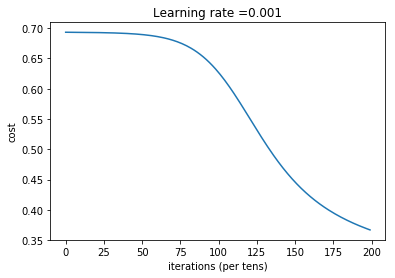

In [21]:
parameters = L_layer_model(x,y, layers_dims, num_iterations = 20000, print_cost = True)

In [22]:
y_predict=predict(parameters, x)

In [23]:
np.equal(y_predict,y).sum()

164